In [6]:
## data loader 
import os
import numpy as np
import pandas as pd
import nibabel as nib
from torch.utils.data import Dataset


In [9]:


import torch
from pathlib import Path
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [11]:
import sys
print("Python version:", sys.version)
print("Python executable:", sys.executable)

Python version: 3.8.20 (default, Oct  3 2024, 15:24:27) 
[GCC 11.2.0]
Python executable: /sc/home/masoumeh.javanbakhat/conda3/envs/myenv/bin/python


In [10]:
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [18]:
adni_dataset = AdniMRIDataset2D(annotations_file=ANNOTATION_PATH, img_dir=IMG_DIR)

In [4]:
print(len(adni_dataset[0]))

2


In [5]:
img, label = adni_dataset[0]

In [6]:
img.shape


(1, 256, 256)

In [9]:
# let's look at pixel intensities
print(f'min of pixel intensities:{img.min()}')

print(f'max of pixel instensities:{img.max()}')


min of pixel intensities:0
max of pixel instensities:255


In [7]:
print(label)

0


In [8]:
print(type(img))

<class 'numpy.ndarray'>


In [10]:
img_tr = np.transpose(img, (1, 2, 0))

In [11]:
img_tr.shape

(256, 256, 1)

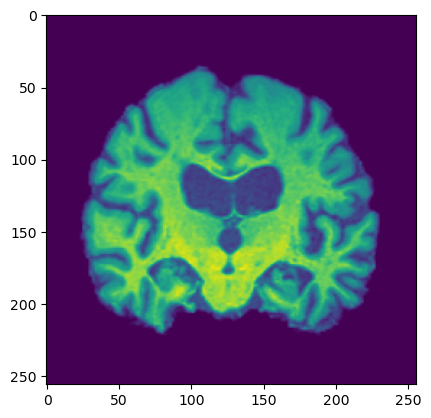

In [11]:
plt.imshow(img_tr)

In [12]:
annot = pd.read_csv(ANNOTATION_PATH)

In [13]:
print(type(annot))

<class 'pandas.core.frame.DataFrame'>


In [14]:
labels = [annot['group'].iloc[idx] for idx in range(len(annot))]

In [15]:
labels_np = np.array(labels)

In [16]:
np.unique(labels_np)

array([0, 1])

In [17]:
len(labels)

9183

In [33]:
labels[500]

0

In [34]:
labels[600]

0

In [36]:
indices = np.where(labels_np == 1)[0]

In [37]:
print(indices)

[   8    9   10 ... 9154 9177 9178]


In [38]:
labels[8]

1

In [39]:
labels[1]

0

In [40]:
labels[9]

1

In [41]:
labels[10]

1

In [18]:
img10,label10 = adni_dataset[10]

/dhc/groups/fglippert/adni_t1_mprage/T1_3T_coronal_slice/T1_3T_coronal_mni_linear_hippo_resolution256/group_by_hippocampus/S785401.nii.gz


In [19]:
img10_tr = np.transpose(img10,(1,2,0))

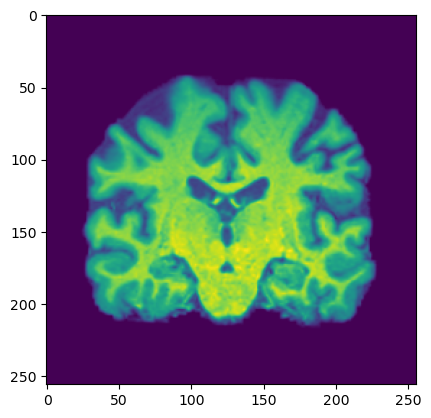

In [20]:
plt.imshow(img10_tr)

- I make seperate groups here, based on label:


In [17]:
adni_dataset = AdniMRIDataset2D(annotations_file=ANNOTATION_PATH, img_dir=IMG_DIR)

In [18]:
print(len(adni_dataset))

9183


In [14]:
img0,label0 = adni_dataset[0]

print(type(img0))

print(img0.shape)

<class 'numpy.ndarray'>
(1, 256, 256)


In [ ]:
# Concatenate along the first axis (axis=0) to form a single numpy array
concatenated_array = np.concatenate(list_of_arrays, axis=0)

# Check the shape of the resulting array
print(concatenated_array.shape)

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


In [19]:
def get_groups(dataset):
    
    group0 = []
    group1 = []
    
    for img,label in dataset:
        
        if label==0:
            group0.append(img)
            
        else:
            group1.append(img)
    
    group0 = np.concatenate(group0, axis=0)        
    group1 = np.concatenate(group1, axis=0)
    
    return(group0, group1)

In [20]:
group0, group1 = get_groups(adni_dataset)

print(group0.shape)

print(group1.shape)

(4591, 256, 256)
(4592, 256, 256)


- In below, note that concatentae, vstack and hstack have the same results.

In [5]:
a = np.random.randn(1,3)

b = np.random.randn(1,3)

c = np.concatenate([a,b], axis=0)

print(f'c:{c.shape}')

d = np.concatenate([a,b],axis=1)

print(f'd:{d.shape}')


e = np.vstack([a,b])

print(f'e:{e.shape}')

f = np.hstack([a,b])

print(f'f:{f.shape}')

c:(2, 3)
d:(1, 6)
e:(2, 3)
f:(1, 6)


- Loading the pretariend model along with weighst

- Extracting embeddings from the last layer on groups 

- Checking statitical test to see if they are statistically different

- Uisng Grad-Cam for back-probabgating test-statistic and visualise differences 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

HID_DIM = 2048
OUT_DIM = 128


#### Renet backbone
class resnet50_fext(nn.Module):
    def __init__(self,pretarin=True):  
        super(resnet50,self).__init__()
        if pretarin:
            backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.encoder = torch.nn.Sequential(*list(backbone.children())[:-1])
    
    def forward(self,x):
        embedding = self.encoder(x)
        embedding = embedding.view(embedding.size()[0],-1)
        return(embedding)
    
    
#### Linear model
class MLP(nn.Module): 
    def __init__(self,in_dim,mlp_hid_size,proj_size):
        super(MLP,self).__init__()
        self.head = nn.Sequential(nn.Linear(in_dim,mlp_hid_size),
                                 nn.BatchNorm1d(mlp_hid_size),
                                 nn.ReLU(),
                                 nn.Linear(mlp_hid_size,proj_size))        
    def forward(self,x):
        x= self.head(x)
        return(x)
    
#### Byol model
class BYOL(nn.Module):
    def __init__(self,net,backbone,hid_dim,out_dim):  
        super(BYOL,self).__init__()
        self.net = net
        self.encoder = torch.nn.Sequential(*list(backbone.children())[:-1])
        self.projection = MLP(in_dim= backbone.fc.in_features,mlp_hid_size=hid_dim,proj_size=out_dim) 
        self.prediction = MLP(in_dim= out_dim,mlp_hid_size=hid_dim,proj_size=out_dim)
        
    def forward(self,x):
        embedding = self.encoder(x)
        embedding = embedding.view(embedding.size()[0],-1)
        project = self.projection(embedding)
        
        if self.net=='target':
            return(project)
        predict = self.prediction(project)
        return(predict)
    
#### SimCLR model    
class SimCLR(nn.Module):
    def __init__(self,backbone,hid_dim,out_dim):  
        super(SimCLR,self).__init__()
        # we get representations from avg_pooling layer
        self.encoder = torch.nn.Sequential(*list(backbone.children())[:-1])
        self.projection = MLP(in_dim= backbone.fc.in_features,mlp_hid_size=hid_dim,proj_size=out_dim) 

    def forward(self,x):        
        embedding = self.encoder(x)
        embedding = embedding.view(embedding.size()[0],-1)
        project = self.projection(embedding)
        return(project)


In [8]:
base_path= "/dhc/home/masoumeh.javanbakhat/netstore-old/Baysian/3D/Explainability/Retina_Codes"

root_dir = Path(base_path) 

checkpoint_dir = root_dir / 'self_supervised' / 'simclr' / 'simclr_ckpts'

pre_exp= 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam_dir_last = os.path.join(checkpoint_dir,f'{pre_exp}_last_sclr.pt')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

state_dict = torch.load(sam_dir_last,map_location=device)

## Load model

backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

model = SimCLR(backbone,hid_dim=2048,out_dim=128).to(device)

model.load_state_dict(state_dict['model'])

encoder = torch.nn.Sequential(*list(model.children())[:-1])


In [69]:
# If I want to use a smaller dimension I can use a FC layer as follows 


reduced_dim = 512  # You can adjust this as needed, e.g., 512, 256, 128
fc_layer = nn.Linear(2048, reduced_dim) 

# it outputs hidden representations of dimension 512
reduced_encoder = nn.Sequential(encoder, fc_layer)

In [74]:
sample_input = torch.randn(1, 3, 224, 224).to(device)

encoder_output = encoder(sample_input)
encoder_output = encoder_output.squeeze()  # This removes the extra dimension, if any
latent_representation = fc_layer(encoder_output)
print(latent_representation.shape)

torch.Size([512])


In [11]:
def get_embeddings_from_numpy(encoder, images_np, device,gr=1,batch_size=32):
    """Takes a numpy array of images, extract embedding vectors, return embeddings"""
    encoder.eval()
    embeddings_list = []
    
    # ImageNet mean and std values
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)  
    IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)  
    
    # Convert numpy array to torch tensor and move to device
    images_tensor = torch.tensor(images_np).unsqueeze(1).to(device).float()  # Assuming images_np is of shape (n_samples, 1, 256, 256)
    images_tensor = images_tensor.repeat(1, 3, 1, 1) # create image with 3 channels
    
    # Apply ImageNet normalization
    images_tensor = (images_tensor - IMAGENET_MEAN) / IMAGENET_STD
    
    reduced_dim = 512  # You can adjust this as needed, e.g., 512, 256, 128
    fc_layer = nn.Linear(2048, reduced_dim)
    
    print(f'shape of tensor:{images_tensor.shape}')
    # If you want to process the data in batches
    num_samples = images_tensor.size(0)
    for i in range(0, num_samples, batch_size):
        batch = images_tensor[i:i + batch_size]
        
        # Ensure the batch is on the right device
        batch = batch.to(device)
        
        # Get embeddings from the model
        with torch.no_grad():
            embeddings = encoder(batch)
            embeddings = embeddings.view(embeddings.size(0), -1)  # Flatten embeddings if needed
            #embeddings = fc_layer(embeddings)
        # Append the embeddings
        embeddings_list.append(embeddings.cpu().numpy())
        
    n = embeddings_list[0].shape[1]
    
    path_embed = os.path.join('./adni_embed',f'embed_gr{gr}_{n}_nr.npy')
    
    gr_embed = np.vstack(embeddings_list)
    
    print(f'shape of embeddings:{gr_embed.shape}')
    
    np.save(path_embed,gr_embed)

    return gr_embed

- In below operations I used ImageNet normalization technique 

In [12]:
group0_embed_nr = get_embeddings_from_numpy(encoder=encoder, images_np=group0, device=device,gr=1,batch_size=64)

group1_embed_nr = get_embeddings_from_numpy(encoder=encoder, images_np=group1, device=device,gr=2,batch_size=64)

shape of tensor:torch.Size([4591, 3, 256, 256])
shape of embeddings:(4591, 2048)
shape of tensor:torch.Size([4592, 3, 256, 256])
shape of embeddings:(4592, 2048)


In [15]:
group0_embed = get_embeddings_from_numpy(encoder=encoder, images_np=group0, device=device, batch_size=64)

group1_embed = get_embeddings_from_numpy(encoder=encoder, images_np=group1, device=device, batch_size=64)

shape of tensor:torch.Size([4591, 3, 256, 256])
shape of tensor:torch.Size([4592, 3, 256, 256])


In [18]:
print(group0_embed.shape)

print(group1_embed.shape)

(4591, 2048)
(4592, 2048)


In [21]:
path = './adni_embed'

os.makedirs(path, exist_ok=True)

In [22]:
path_gr1_embed = os.path.join(path,'embed_gr1.npy')

path_gr2_embed = os.path.join(path,'embed_gr2.npy')

In [21]:
## Now, let's save embeddings of each group

np.save(path_gr1_embed,group0_embed)

np.save(path_gr2_embed,group1_embed)

In [15]:
print(type(group0_embed))

print(type(group1_embed))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


- I try to reduce the dimension

- I chose embeddings = 512

In [ ]:
group0_embed = get_embeddings_from_numpy(encoder=reduced_encoder, images_np=group0, device=device, batch_size=64)

group1_embed = get_embeddings_from_numpy(encoder=reduced_encoder, images_np=group1, device=device, batch_size=64)

In [13]:
## check for statistically difference 

class MMDTest:
    def __init__(self, features_X, features_Y, n_perm=1000):
        
        self.n_perm = n_perm
        self.features_X = features_X
        self.features_Y = features_Y
        
    def _compute_mmd(self, features_X, features_Y):
        
        mean_fX = features_X.mean(0)
        mean_fY = features_Y.mean(0)
        D = mean_fX - mean_fY
        statistic = np.linalg.norm(D)**2
        return statistic
    
    def _compute_p_value(self):
        
        # compute real test statistic
        stat = self._compute_mmd(self.features_X, self.features_Y)
        n, m = len(self.features_X), len(self.features_Y)
        l = n + m
        features_Z = np.vstack((self.features_X, self.features_Y))
        
        # compute null samples
        resampled_vals = np.empty(self.n_perm)
        for i in range(self.n_perm):
            index = np.random.permutation(l) # it permutes indices from 0 to l
            feats_X, feats_Y = features_Z[index[:n]], features_Z[index[n:]]
            resampled_vals[i] = self._compute_mmd(feats_X, feats_Y)
            
        resampled_vals.sort()
        #p_val = np.mean(stat < resampled_vals)
        p_val = (np.sum(stat<= resampled_vals)+1)/(self.n_perm+1)
        return p_val

In [ ]:
mmd = MMDTest(group0_embed, group1_embed)

In [18]:
p_val = mmd._compute_p_value()

In [19]:
print(p_val)

0.000999000999000999


In [14]:
mmd_nr = MMDTest(group0_embed_nr, group1_embed_nr) 

p_val = mmd_nr._compute_p_value()

In [15]:
print(p_val)

0.000999000999000999


- They are statistically different

- Now let's bcak probagte the test-statitic to see what we can visualaise

- Lets also look at p-value for smaller number of samples

In [23]:
gr1_embed = np.load(path_gr1_embed)

gr2_embed = np.load(path_gr2_embed)

print(gr1_embed.shape)

print(gr2_embed.shape)

(4591, 2048)
(4592, 2048)


In [25]:
gr1_embed_100 = gr1_embed[:100,:]

gr2_embed_100 = gr2_embed[:100,:]

In [26]:
mmd_100 = MMDTest(gr1_embed_100, gr2_embed_100)

In [27]:
p_val = mmd_100._compute_p_value()

In [28]:
print(p_val)

0.000999000999000999


In [30]:
gr1_embed_200 = gr1_embed[:200,:]

gr2_embed_200 = gr2_embed[:200,:]

In [31]:
mmd_200 = MMDTest(gr1_embed_200, gr2_embed_200)

p_val = mmd_200._compute_p_value()

print(p_val)

0.000999000999000999


- Here, let's check how many samples do we need to obtain a p-value belwo our alpha value

In [24]:
print(gr1_embed.shape)

print(gr2_embed.shape)

(4591, 2048)
(4592, 2048)


In [16]:
import sys
import os
sys.path.append(os.path.abspath("src"))

import gradcam

from gradcam import GradCAM

- I can compute mean of embeddings as follows: 

 

In [ ]:


def get_mean_embeddings(gcam, dataloader, device, latent_dim=2048):
    """Computes the mean embeddings while keeping gradients for backpropagation"""
    mean_embed = None
    count_f = 0  

    for images in dataloader:
        images = images.to(device)
        embeddings = gcam.forward(images)  # Get embeddings
        embeddings = embeddings.view(embeddings.size(0), -1)  # Flatten

        batch_mean = embeddings.mean(dim=0)  # Compute mean per batch

        if mean_embed is None:
            mean_embed = batch_mean  # Initialize running mean
        else:
            # Online update for running mean (preserves gradient tracking)
            count_f += 1
            mean_embed = mean_embed + (batch_mean - mean_embed) / count_f  

    return mean_embed


In [17]:
# This is my first code (old code)

def get_mean_embeddings(gcam, dataloader, device, latent_dim=2048):
        """Takes dataloader of each group, extract embedding vectors, return mean embeddings"""
        # Initialize accumulators for healthy and unhealthy groups
        sum_f = torch.zeros_like(torch.zeros(latent_dim)).to(device)  
        count_f = 0 # Count of samples in each group
        for images in dataloader:
            images = images.to(device)
            embeddings = gcam.forward(images)
            embeddings = embeddings.view(embeddings.size()[0],-1)
            sum_f += embeddings.sum(dim=0)  # Sum of embeddings for this batch
            count_f += embeddings.size(0) 
        mean_embed = sum_f / count_f if count_f > 0 else torch.zeros_like(sum_f) 
        del sum_f, embeddings, images
        torch.cuda.empty_cache()
        return mean_embed

- I corrected image normalisation below too.

In [18]:
def convert_to_tensor(group, device):
    group_tensor = torch.tensor(group).unsqueeze(1).to(device).float()  # Assuming images_np is of shape (n_samples, 1, 256, 256)
    group_tensor = group_tensor.repeat(1, 3, 1, 1) # create image with 3 channels
    
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)  
    IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    # Apply ImageNet normalization
    group_tensor = (group_tensor - IMAGENET_MEAN) / IMAGENET_STD
    
    return(group_tensor)

In [19]:
def get_loader(group0, group1,device, bs=64):
    group0_tensor = convert_to_tensor(group0, device)
    group1_tensor = convert_to_tensor(group1, device)
    
    print(group0_tensor.shape)
    print(group1_tensor.shape)
    
    group0_loader = DataLoader(group0_tensor, batch_size=bs, shuffle=False, drop_last=True)
    group1_loader = DataLoader(group1_tensor, batch_size=bs, shuffle=False, drop_last=True)
    
    return(group0_loader, group1_loader)
    

- Now I check, how data in dataloaders are defined.

In [21]:
gr0_nr_loader, gr1_nr_loader = get_loader(gr0_100, gr1_100,device, bs=64)

torch.Size([100, 3, 256, 256])
torch.Size([100, 3, 256, 256])


In [20]:
gr0_100 = group0[:100]

gr1_100 = group1[:100]

In [58]:
gr0_loader, gr1_loader =  get_loader(gr0_100, gr1_100,device, bs=64)

torch.Size([100, 3, 256, 256])
torch.Size([100, 3, 256, 256])


In [60]:
print(len(gr0_loader.dataset))

100


In [39]:
for batch in gr0_loader:
    
    print(batch.shape)
    
    break

torch.Size([64, 3, 256, 256])


In [40]:
gr0_loader, gr1_loader =  get_loader(gr0_100, gr1_100,device, bs=64)

torch.Size([100, 3, 256, 256])
torch.Size([100, 3, 256, 256])


In [41]:
for batch in gr0_loader:
    print(len(batch))
    break

64


In [44]:
def backprobagate_statistics(model,group0, group1,target_layer, bs, device):
    
    """Calculate the test statistic for different groups of DR."""
    # convert numpy groups to tensors
    group0_loader, group1_loader = get_loader(group0, group1,device, bs=64)
    
    gcam = GradCAM(model, target_layer=target_layer, relu=True, device=device)
    # Calculate mean embeddings
    group0_mean = get_mean_embeddings(gcam,group0_loader,device)
    group1_mean = get_mean_embeddings(gcam,group1_loader,device)
    D = group0_mean - group1_mean
    print(f'group0_mean:{group0_mean.shape}')
    print(f'group1_mean:{group1_mean.shape}')
    test_statistic = torch.norm(D, p=2)
    return(test_statistic, D, gcam)

In [45]:
def process_attributions(dataloader,gcam,device,backprop_value):
    
    """Process and return GradCAM attributions in batches."""
    attributions_list = []
    embed_list = [] # save embeddings as numpy array
    # Compute attribution maps for each group
    for images, _ in dataloader:
        images = images.to(device)
        embeddings = gcam.forward(images)
        embeddings = embeddings.view(embeddings.size()[0],-1).cpu().data.numpy()
        embed_list.append(embeddings)
        del embeddings
        gcam.backward(backprop_value)
        attributions = gcam.generate()
        attributions = attributions.squeeze().cpu().data.numpy()
        attributions_list.append(attributions)
    return np.vstack(attributions_list), np.vstack(embed_list) 

In [46]:
def run(model,group0,group1,device,target_layer,bs=64,backprop_type='test_statistic',latent_dim_idx=None):
    
    """Main experiment function."""
    test_statistic, D, gcam = backprobagate_statistics(model, group0, group1,target_layer, bs, device)

    backprop_value = test_statistic
    
    group0_loader, group1_loader = get_loader(group0, group1,device)
        
    group0_attr, group0_embed = process_attributions(group0_loader, gcam, backprop_value)
    group1_attr, group1_embed = process_attributions(group1_loader, gcam, backprop_value) 
        
    #save_attributions(group0_attr, group1_attr,latent_dim_idx)
    
    print(f'gr1:{group0_attr.shape}')
    print(f'gr2:{group2_attr.shape}')
    
    return(group0_attr, group1_attr)
        

In [12]:
Target_Layer = '0.7.2.conv3'

In [48]:
group0.shape

(4591, 256, 256)

In [19]:
gr0_64 = group0[:64,:,:]

gr1_64 = group1[:64,:,:]

print(gr0_64.shape)

print(gr1_64.shape)

(64, 256, 256)
(64, 256, 256)


In [ ]:
gr0_att, gr1_att = run(model=encoder,group0=gr0_200,group1=gr1_200,device=device,target_layer=Target_Layer,bs=8,backprop_type='test_statistic', latent_dim_idx=None)

### Changes in the code:

 - **First**: 
 
    - compute embeddings for the first group and save them => **$\mu_{1}$**
    - compute embeddings for the second group and save them => **$\mu_{2}$**
 - **Second**:
 
   - Load saved embeddings 
   
   - For each batch, compute emebdding in forward pass and compute => **$\mu_{1}' = \mu_{1} - d_{i}+d_{i}$**, where $d_{i}$ is the embedding of i-th batch.

   - Compute test-statistic **$S$**
   
   - Backprobagate test-statistic **$S$** to get heatmaps
 

In [ ]:
## Wei cheng code

pre_embed_group0 = torch.tensor(pre_embed_group0).to(device)
pre_embed_group1 = torch.tensor(pre_embed_group1).to(device)
    
# convert numpy groups to tensors
group0_loader, group1_loader = get_loader(group0, group1, device, bs=bs)
    
gcam = GradCAM(model, 
               target_layer=target_layer,
               relu=True, device=device)
# Calculate sum embeddings for each group
pre_embed_group0_sum = pre_embed_group0.sum(dim=0)
pre_embed_group1_sum = pre_embed_group1.sum(dim=0)
mean_embeddings_group0 = pre_embed_group0_sum / len(group0_loader) # this is wrong => (len(group0_loader.dataset))
mean_embeddings_group1 = pre_embed_group1_sum / len(group1_loader) # this is wrong
    
diff_group0 = []
diff_group1 = []
for i, images in enumerate(group0_loader):
    images = images.to(device)
    current_embed = get_mean_embeddings_per_batch(gcam, images)
    embeddings = pre_embed_group0_sum + current_embed - pre_embed_group0[i * bs: (i + 1) * bs].sum(dim=0)
    batch_mean_embeddings_group0 = embeddings / len(group0_loader)#this is wrong,it should be divided by len dataset
    ## statistical test
    mmd = torch.norm(batch_mean_embeddings_group0 - mean_embeddings_group1, p=2) 
    gcam.backward(mmd)
    gcam_activation0 = gcam.generate().squeeze(dim=1)
    diff_group0.append(gcam_activation0.cpu().detach().numpy())
    torch.cuda.empty_cache() 



In [27]:
def backprobagate_test_statistic(dataloader,gcam,device,emb_gr1,emb_gr2,gr1=True,bs=64):
    
    """Backprobagate test-statistic and get heatmaps"""
    attributions_list = []
    
    # Step 1: Compute the initial sum embeddings for group 1 and group 2  # Sum of group 1 embeddings
    emb_gr1_tensor = torch.tensor(emb_gr1).to(device)
    sum_gr1 = emb_gr1_tensor.sum(dim=0, keepdims=True) # Sum group 1
    #print(f'sum_gr1_shape:{sum_gr1.shape}')
    
    emb_gr2_tensor = torch.tensor(emb_gr2).to(device)
    sum_gr2 = emb_gr2_tensor.sum(dim=0, keepdims=True) # Sum group 1
    #print(f'sum_gr2_shape:{sum_gr1.shape}')
    
    print(f'sum_gr1_req_gr:{sum_gr1.requires_grad}')
    print(f'sum_gr2_req_gr:{sum_gr2.requires_grad}')
    
    print(f'sum_gr1:{sum_gr1.shape}')
    print(f'sum_gr2:{sum_gr2.shape}')
    
    batch_count = 0
    
    # Compute attribution maps for each group
    for i,images in enumerate(dataloader):
        images = images.to(device)
        embeddings = gcam.forward(images)
        embeddings = embeddings.view(embeddings.size()[0],-1)
        
        batch_count+=1
        print(f'number of batches:{batch_count}')
        
        print(f'embedding:{embeddings.shape}')
        
        batch_size = embeddings.size(0)
        
        if gr1:
            # Subtract the old batch embeddings, then add the new batch embeddings for group1
            sum_gr1 = sum_gr1 - emb_gr1_tensor[i * bs: (i + 1) * bs].sum(dim=0)  # Remove batch embeddings
            sum_gr1 = sum_gr1 + embeddings.sum(dim=0, keepdim=True)  # Add new batch embeddings
            
        else:
            # Subtract the old batch embeddings, then add the new batch embeddings for group2
            sum_gr2 = sum_gr2 - emb_gr2_tensor[i * bs: (i + 1) * bs].sum(dim=0)  # Remove batch embeddings
            sum_gr2 = sum_gr2 + embeddings.sum(dim=0, keepdim=True)   # Add new batch embeddings
            
        del embeddings
        # clear cuda
        torch.cuda.empty_cache()
        
        # compute test-statistic
        mean_gr1 = sum_gr1/len(emb_gr1)
        mean_gr2 = sum_gr2/len(emb_gr2)
        
        D = mean_gr1 - mean_gr2
        print(f'shape of test_statistic:{D.shape}')
        test_statistic = torch.norm(D, p=2)
        # check if test_statistic has computational graph
        print(f'\n test_statistic_req_grad:{test_statistic.requires_grad}')
        
        gcam.backward(test_statistic)
        attributions = gcam.generate()
        attributions = attributions.squeeze().cpu().data.numpy()
        attributions_list.append(attributions)
        
        mmd = MMDTest(emb_gr1, emb_gr2)
        
        p_val = mmd._compute_p_value()
        
        print(f'p_val:{p_val}')
        
        if batch_count ==4:
            break
    return np.vstack(attributions_list)


In [28]:
def get_heatmaps(model,group0,group1,device,target_layer,bs=64):
    
    # get dataloaders
    group0_loader, group1_loader = get_loader(group0,group1,device)
    
    batch_gr0 = next(iter(group0_loader))
    batch_gr1 = next(iter(group1_loader))
    
    print(f'batch_gr0:{len(batch_gr0)}')
    print(f'batch_gr1:{len(batch_gr1)}')
    
    # load embeddings
    path = './adni_embed'
    
    path_gr0_embed = os.path.join(path,'embed_gr1.npy')
    path_gr1_embed = os.path.join(path,'embed_gr2.npy')
    
    embed_gr0 = np.load(path_gr0_embed)
    embed_gr1 = np.load(path_gr1_embed)
    
    print(f'gr1_embed:{embed_gr0.shape}')
    print(f'gr2_embed:{embed_gr1.shape}')
    
    # create gradCAM
    gcam = GradCAM(model,target_layer=target_layer,relu=True,device=device)
    
    group0_attr = backprobagate_test_statistic(group0_loader,gcam,device,embed_gr0,embed_gr1,gr1=True,bs=bs)
    group1_attr = backprobagate_test_statistic(group1_loader,gcam,device,embed_gr0,embed_gr1,gr1=False,bs=bs)
    
    print(f'gr0_heat_shape:{group0_attr.shape}')
    print(f'gr1_heat_shape:{group1_attr.shape}')
    
    n = group0_attr.shape[0]
    m = group1_attr.shape[1]
    
    #save_attributions(group0_attr, group1_attr,latent_dim_idx)
    full_path1 = os.path.join('./adni_heatmaps',f'gr1_scd_{n}')
    full_path2 = os.path.join('./adni_heatmaps',f'gr2_scd_{m}')
     
    print(f'gr1:{group0_attr.shape}')
    print(f'gr2:{group1_attr.shape}')
    
    np.save(full_path1, group0_attr)
    np.save(full_path2, group1_attr)
    
    return(group0_attr,group1_attr)


In [ ]:
gr0_att, gr1_att = get_heatmaps(model=encoder,group0=group0,group1=group1,device=device,target_layer='0.7.2.conv3',bs=64)

In [16]:
print(group0.shape)
print(group1.shape)

(4591, 256, 256)
(4592, 256, 256)


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


- Now I will look at the heatmaps

In [42]:
path1= './adni_heatmaps/gr1_scd_256.npy'

heat_gr1 = np.load(path1)

path2 = './adni_heatmaps/gr2_scd_256.npy'

heat_gr2 = np.load(path2)

In [43]:
print(heat_gr1.shape)

print(heat_gr2.shape)

(256, 256, 256)
(256, 256, 256)


In [54]:
heat0_gr1 = heat_gr1[0]
heat0_gr2 = heat_gr2[0]

heat1_gr1 = heat_gr1[1]
heat1_gr2 = heat_gr2[1]

heat2_gr1 = heat_gr1[2]
heat2_gr2 = heat_gr2[2]

heat3_gr1 = heat_gr1[3]
heat3_gr2 = heat_gr2[3]

heat4_gr1 = heat_gr1[4]
heat4_gr2 = heat_gr2[4]

heat5_gr1 = heat_gr1[5]
heat5_gr2 = heat_gr2[5]

heat6_gr1 = heat_gr1[6]
heat6_gr2 = heat_gr2[6]

heat7_gr1 = heat_gr1[7]
heat7_gr2 = heat_gr2[7]

heat8_gr1 = heat_gr1[8]
heat8_gr2 = heat_gr2[8]

heat9_gr1 = heat_gr1[9]
heat9_gr2 = heat_gr2[9]

heat10_gr1= heat_gr1[10]
heat10_gr2= heat_gr2[10]

heat40_gr1= heat_gr1[40]
heat40_gr2= heat_gr2[40]

heat60_gr1= heat_gr1[60]
heat60_gr2= heat_gr2[60]



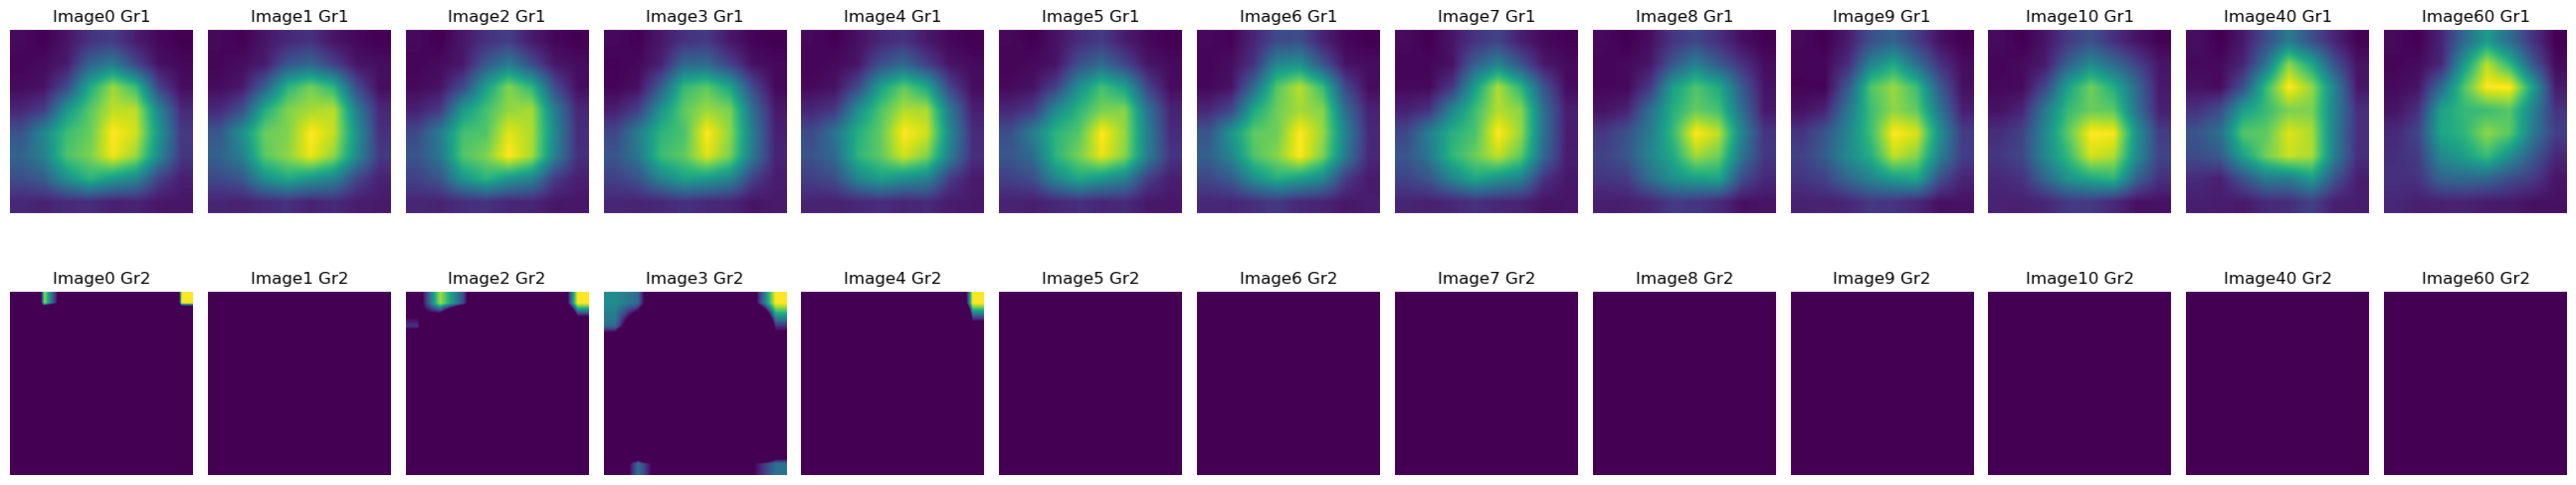

In [57]:
import matplotlib.pyplot as plt

# Grouping images
group1_images = [
    heat0_gr1, heat1_gr1, heat2_gr1, heat3_gr1, heat4_gr1,
    heat5_gr1, heat6_gr1, heat7_gr1, heat8_gr1, heat9_gr1,
    heat10_gr1, heat40_gr1, heat60_gr1
]

group2_images = [
    heat0_gr2, heat1_gr2, heat2_gr2, heat3_gr2, heat4_gr2,
    heat5_gr2, heat6_gr2, heat7_gr2, heat8_gr2, heat9_gr2,
    heat10_gr2, heat40_gr2, heat60_gr2
]

num_images = len(group1_images)  # Number of images per group

fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(num_images * 2, 6))  # 2 rows, N columns

# Titles for each image
titles1 = [f"Image{i} Gr1" for i in [0,1,2,3,4,5,6,7,8,9,10,40,60]]

titles2 = [f"Image{i} Gr2" for i in [0,1,2,3,4,5,6,7,8,9,10,40,60]]

# Plot Group 1 in the first row
for i in range(num_images):
    axes[0, i].imshow(group1_images[i], cmap='viridis')  
    axes[0, i].set_title(titles1[i])
    axes[0, i].axis('off')

# Plot Group 2 in the second row
for i in range(num_images):
    axes[1, i].imshow(group2_images[i], cmap='viridis') 
    axes[1, i].set_title(titles2[i])
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


### Importing heatmaps and looking at them 

In [33]:
import numpy as np

from PIL import Image

In [35]:
class ZeroGradientError(Exception):
    """Custom exception to handle cases where the gradient is zero."""
    pass

def save_cam_with_alpha(image, gcam, alpha=0.5):
    
    # Convert grayscale image to 3 channels if needed
    if len(image.shape) == 2:  # Grayscale image (H, W)
        image = np.stack([image] * 3, axis=-1)  # Convert to (H, W, 3)
    
    # Normalize the Grad-CAM values to [0, 1]
    # Normalize the Grad-CAM values to [0, 1], handling zero gradients
    gcam_min = np.min(gcam)
    gcam_max = np.max(gcam)
    
    try:
        if gcam_max == gcam_min:  # If all values are zero, raise an error
            raise ZeroGradientError("Gradient map contains only zero values, cannot overlay.")
        gcam = (gcam - gcam_min) / (gcam_max - gcam_min)  # Normalize gradient map
    except ZeroGradientError as e:
        print(f"Error: {e}")
        # Handle the error (for example, return the original image or skip processing)
        return image, image  # Return the original image if error occurs
    
    # Resize Grad-CAM to match the image dimensions (224x224)
    h, w = image.shape[:2]  # Get height and width (height, width) from image shape
    gcam_resized = np.array(Image.fromarray(gcam).resize((w, h), Image.BILINEAR))

    # Apply a colormap (similar to cv2.applyColorMap)
    gcam_colored = plt.cm.jet(gcam_resized)[:, :, :3] * 255  # Apply colormap and select RGB channels
    gcam_colored = gcam_colored.astype(np.uint8)

    # Add Grad-CAM on top of the original image using alpha blending
    heatmap = gcam_colored.astype(np.float64)
    
    # checking dimension of image and heatmaps
    print(f'heatmap:{heatmap.shape}')
    print(f'image:{image.shape}')
    
    overlaid_image = (alpha * heatmap + (1 - alpha) * image.astype(np.float64)).astype(np.uint8)

    return image, overlaid_image


In [11]:
path1 = './adni_heatmaps/gr1.npy'

path2 = './adni_heatmaps/gr2.npy'

In [12]:
heat1 = np.load(path1)

heat2 = np.load(path2)

In [13]:
print(heat1.shape)

print(heat2.shape)

(64, 256, 256)
(64, 256, 256)


In [34]:
import sys
import os

# Get the absolute path of the 'src' directory
src_path = os.path.abspath("src")

# Add 'src' to system path
if src_path not in sys.path:
    sys.path.append(src_path)
    
import utils

- To use functions from utils, we can do it as follows:

  - utils.save_cam_with_alpha(...)
  - utils.overlay_heatmap_single(...)

In [20]:
gr0 = gr0_64

gr1 = gr1_64

In [25]:
sing_img0 = gr0[0]

In [26]:
sing_img0.shape

(256, 256)

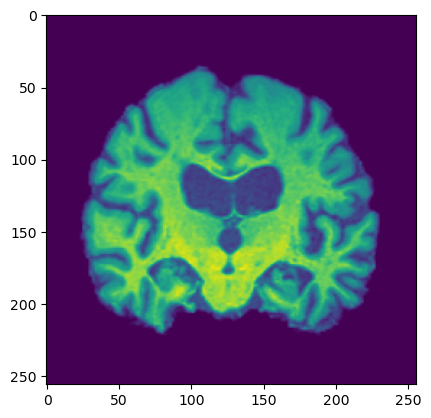

In [27]:
plt.imshow(sing_img0)

In [28]:
sing_img1 = gr1[0]

In [29]:
sing_img1.shape

(256, 256)

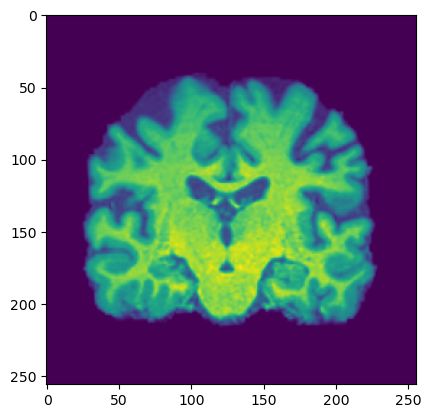

In [30]:
plt.imshow(sing_img1)

In [31]:
print(type(sing_img0))

print(type(sing_img1))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [33]:
print(sing_img0.dtype)

print(sing_img1.dtype)

uint8
uint8


In [38]:
heat_img0_gr0 = heat1[0]

heat_img1_gr1 = heat2[0]

In [49]:
img0_gr0, ov_im0_gr0 = save_cam_with_alpha(sing_img0, heat_img0_gr0, alpha=0.5)

img0_gr1, ov_im0_gr1 = save_cam_with_alpha(sing_img1, heat_img1_gr1, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)


### Heatmaps of group0 

(-0.5, 255.5, 255.5, -0.5)

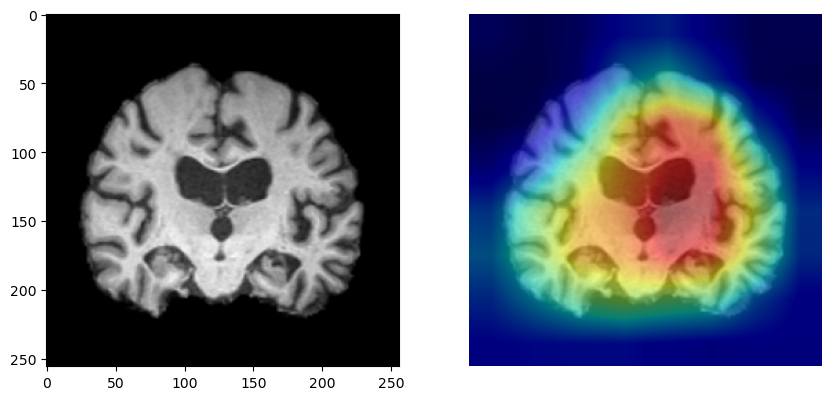

In [53]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img0_gr0)

plt.axis("off")

axes[1].imshow(ov_im0_gr0)

plt.axis("off")

### Heatmaps of group1

In [ ]:
img0_gr1, ov_im0_gr1

(-0.5, 255.5, 255.5, -0.5)

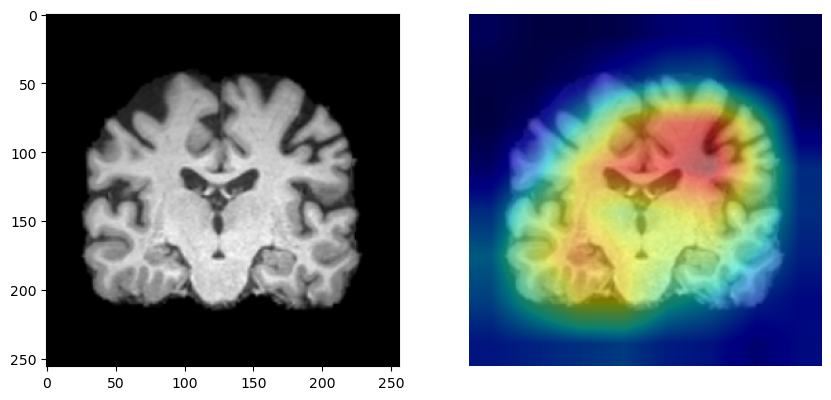

In [54]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img0_gr1)

plt.axis("off")
axes[1].imshow(ov_im0_gr1)

plt.axis("off")

- Let's consider another image in the group

In [56]:
img10_gr0 = gr0[10]

img10_gr1 = gr1[10]

(-0.5, 255.5, 255.5, -0.5)

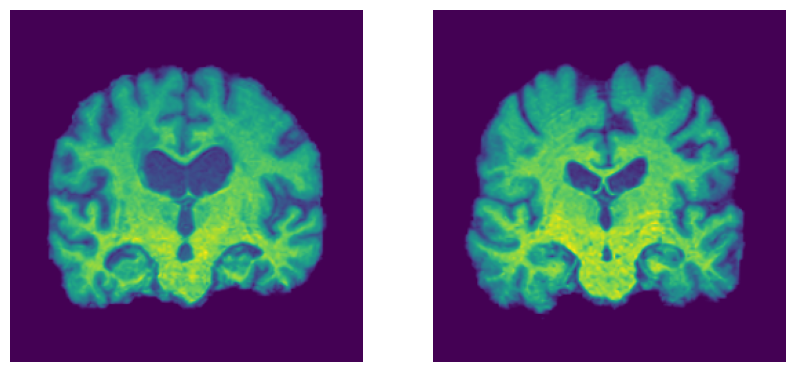

In [58]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img10_gr0)

axes[0].axis("off")

axes[1].imshow(img10_gr1)

axes[1].axis("off")

In [59]:
heat10_gr0 = heat1[10] 

heat10_gr1 = heat2[10]

In [60]:
img10_gr0, ov_im10_gr0 = save_cam_with_alpha(img10_gr0, heat10_gr0, alpha=0.5)

img10_gr1, ov_im10_gr1 = save_cam_with_alpha(img10_gr1, heat10_gr1, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

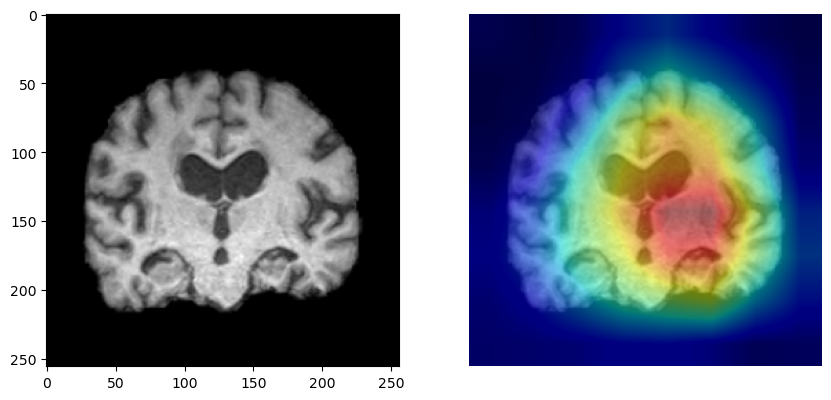

In [61]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img10_gr0)

plt.axis("off")

axes[1].imshow(ov_im10_gr0)

plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

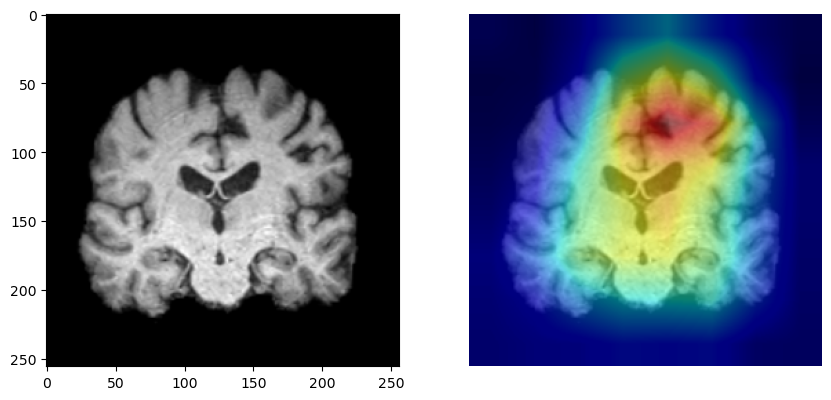

In [62]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img10_gr1)

plt.axis("off")

axes[1].imshow(ov_im10_gr1)

plt.axis("off")

- Let's look at image 40

In [69]:
img40_gr0 = gr0[40]

img40_gr1 = gr1[40]

(-0.5, 255.5, 255.5, -0.5)

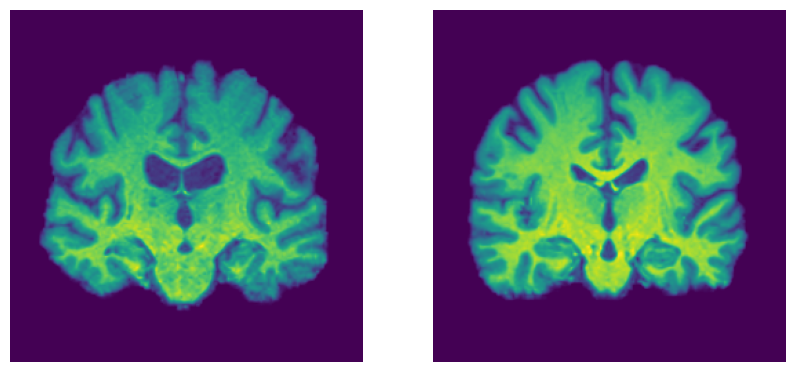

In [70]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img40_gr0)

axes[0].axis("off")

axes[1].imshow(img40_gr1)

axes[1].axis("off")

In [71]:
heat40_gr0 = heat1[40] 

heat40_gr1 = heat2[40]

In [72]:
img40_gr0, ov_im40_gr0 = save_cam_with_alpha(img40_gr0, heat40_gr0, alpha=0.5)

img40_gr1, ov_im40_gr1 = save_cam_with_alpha(img40_gr1, heat40_gr1, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

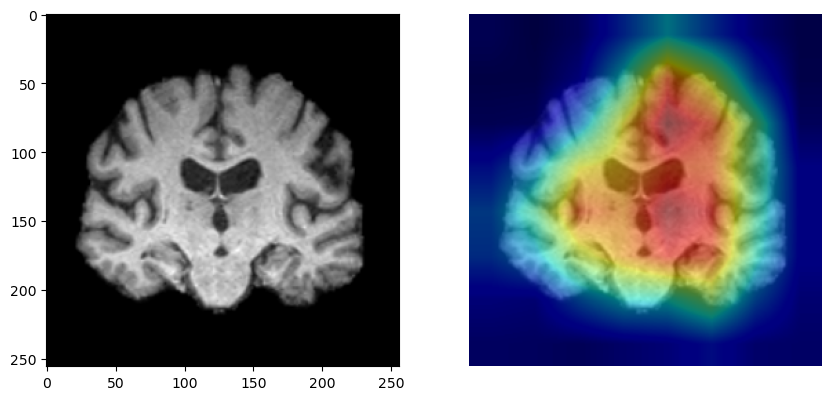

In [73]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img40_gr0)

plt.axis("off")

axes[1].imshow(ov_im40_gr0)

plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

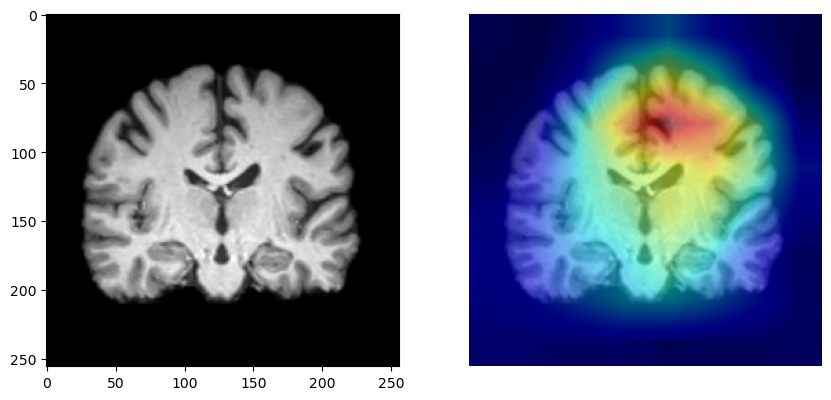

In [74]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img40_gr1)

plt.axis("off")

axes[1].imshow(ov_im40_gr1)

plt.axis("off")

- Let's look at images 50 or 60

In [75]:
img60_gr0 = gr0[60]

img60_gr1 = gr1[60]

(-0.5, 255.5, 255.5, -0.5)

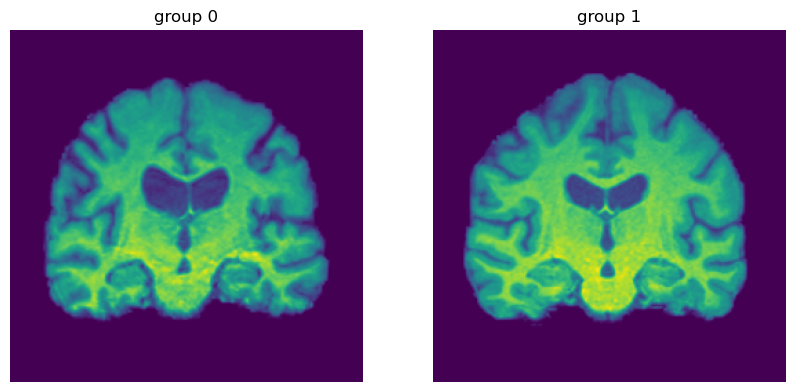

In [79]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img60_gr0)

axes[0].set_title('group 0')

axes[0].axis("off")

axes[1].imshow(img60_gr1)

axes[1].set_title('group 1')
axes[1].axis("off")

In [80]:
heat60_gr0 = heat1[60] 

heat60_gr1 = heat2[60]

In [81]:
img60_gr0, ov_im60_gr0 = save_cam_with_alpha(img60_gr0, heat60_gr0, alpha=0.5)

img60_gr1, ov_im60_gr1 = save_cam_with_alpha(img60_gr1, heat60_gr1, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

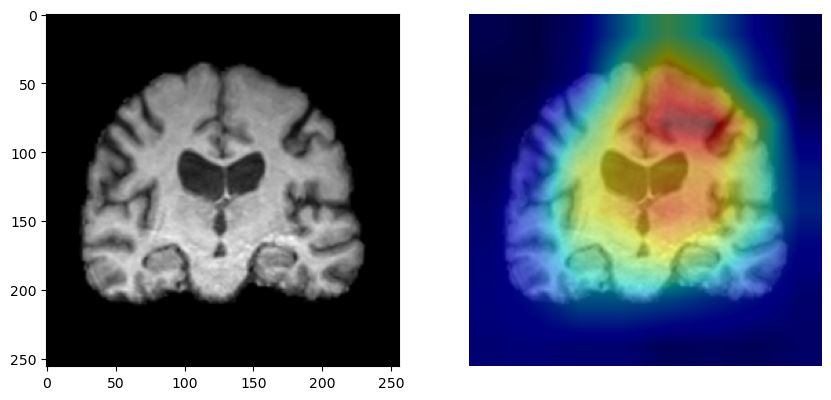

In [82]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img60_gr0)

plt.axis("off")

axes[1].imshow(ov_im60_gr0)

plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

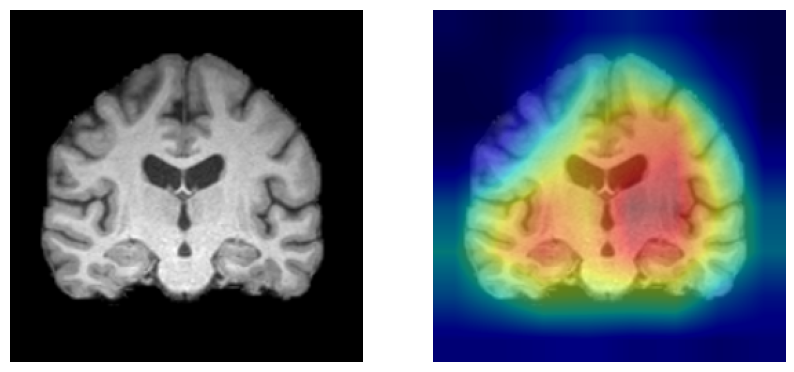

In [84]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img60_gr1)

axes[0].axis("off")

axes[1].imshow(ov_im60_gr1)

plt.axis("off")

- How to adjust alhos:

  - If you want precise attention to specific areas in the heatmap but don't want to lose the context of the original image (e.g., object recognition, localization), try alpha around 0.3 to 0.5.
  
  - Lets change alpha

In [85]:
img60_gr0, ov_im60_gr0_3 = save_cam_with_alpha(img60_gr0, heat60_gr0, alpha=0.3)

img60_gr1, ov_im60_gr1_3 = save_cam_with_alpha(img60_gr1, heat60_gr1, alpha=0.3)

heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

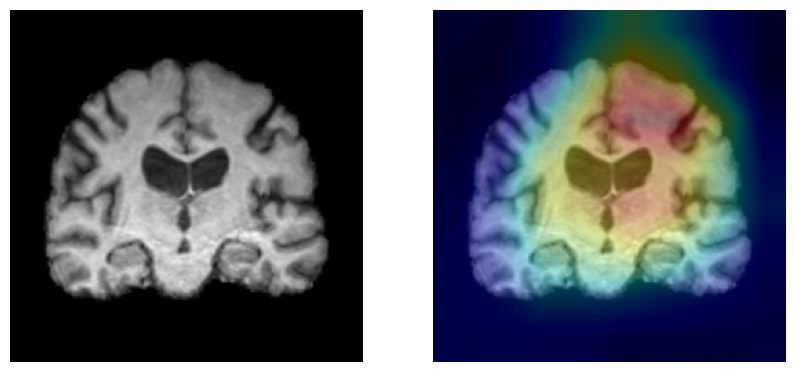

In [87]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img60_gr0)

axes[0].axis("off")

axes[1].imshow(ov_im60_gr0_3)

axes[1].axis("off")

In [88]:
img60_gr0, ov_im60_gr0_4 = save_cam_with_alpha(img60_gr0, heat60_gr0, alpha=0.4)

img60_gr1, ov_im60_gr1_4 = save_cam_with_alpha(img60_gr1, heat60_gr1, alpha=0.4)

heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

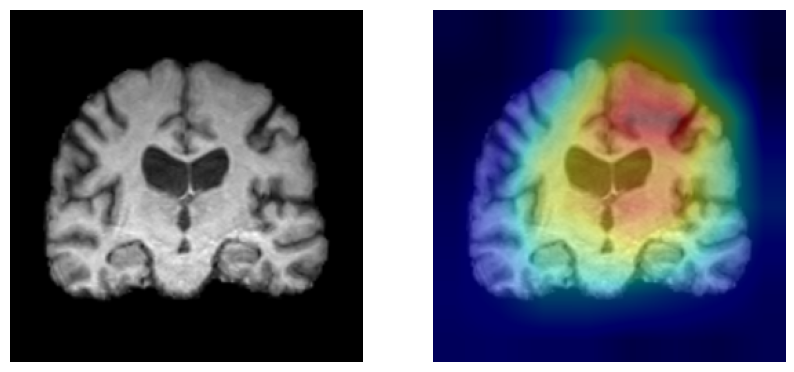

In [89]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img60_gr0)

axes[0].axis("off")

axes[1].imshow(ov_im60_gr0_4)

axes[1].axis("off")

- It seems $\alpha = 0.4$ works better for heatmap visualisation

## Checking modified code 

- Here, I changed the code such that we do not have to use whole samples for backprobagation

In [6]:
# path to heatmaps after returning the normalisation to the previous type: /255.0

path1 = './adni_heatmaps/gr1_100_64_scd.npy'

path2 = './adni_heatmaps/gr2_100_64_scd.npy'

In [7]:
gr1_heat = np.load(path1)

gr2_heat = np.load(path2)

In [8]:
heat0_gr1 = gr1_heat[0]
heat0_gr2 = gr2_heat[0]

In [21]:
group0_100 = group0[:100]
group1_100 = group1[:100]

In [22]:
img0_gr1 = group0_100[0]
img0_gr2 = group1_100[0]

In [37]:
img0_gr1, ov_img0_gr1 = save_cam_with_alpha(img0_gr1, heat0_gr1, alpha=0.5)

img0_gr2, ov_img0_gr2 = save_cam_with_alpha(img0_gr2, heat0_gr2, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)


### First group

Text(0.5, 1.0, 'Heatmap Image0 group1')

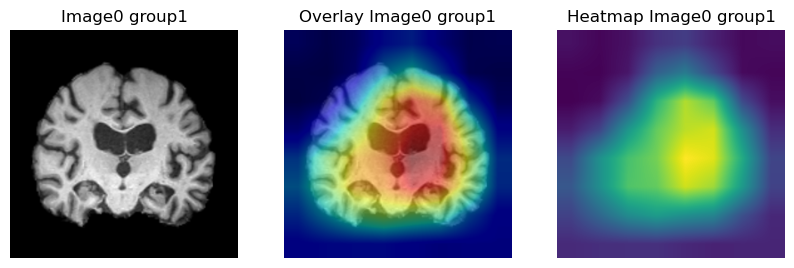

In [46]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img0_gr1)
axes[0].axis("off")
axes[0].set_title('Image0 group1')

axes[1].imshow(ov_img0_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group1')

axes[2].imshow(heat0_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group1')

### Second group

Text(0.5, 1.0, 'Heatmap Image0 group2')

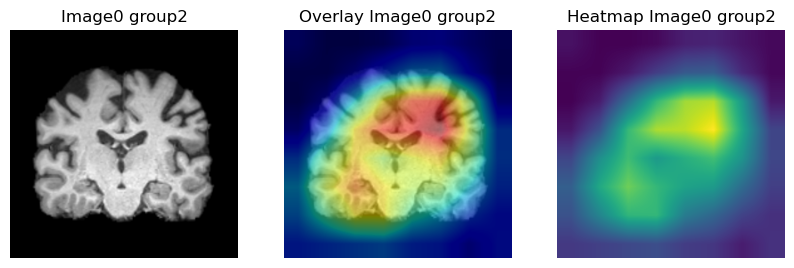

In [47]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img0_gr2)
axes[0].axis("off")
axes[0].set_title('Image0 group2')

axes[1].imshow(ov_img0_gr2)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group2')

axes[2].imshow(heat0_gr2)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group2')

### First group => Image 10

In [73]:
img10_gr1 = group0_100[10]
img10_gr2 = group1_100[10]

heat10_gr1 = gr1_heat[10]
heat10_gr2 = gr2_heat[10]

img10_gr1, ov_img10_gr1 = save_cam_with_alpha(img10_gr1, heat10_gr1, alpha=0.5)

img10_gr2, ov_img10_gr2 = save_cam_with_alpha(img10_gr2, heat10_gr2, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)


Text(0.5, 1.0, 'Heatmap Image10 group1')

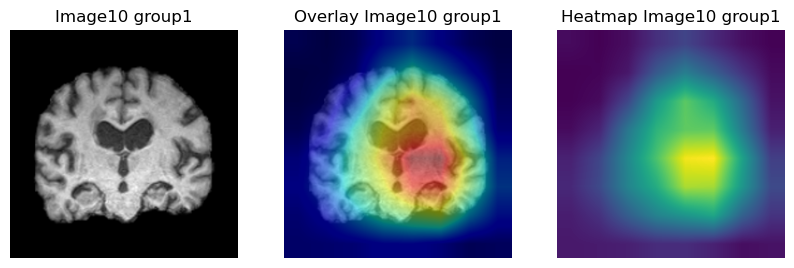

In [74]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img10_gr1)
axes[0].axis("off")
axes[0].set_title('Image10 group1')

axes[1].imshow(ov_img10_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group1')

axes[2].imshow(heat10_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group1')

### Second group => Image 10

Text(0.5, 1.0, 'Heatmap Image10 group2')

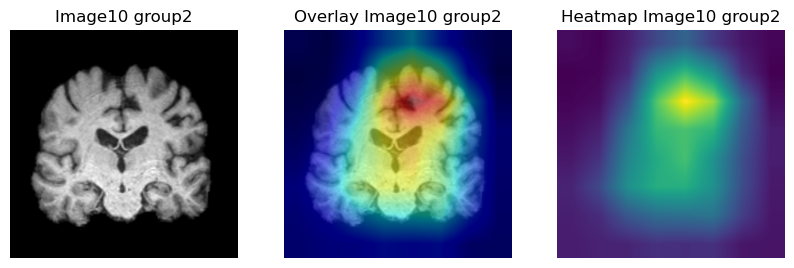

In [75]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img10_gr2)
axes[0].axis("off")
axes[0].set_title('Image10 group2')

axes[1].imshow(ov_img10_gr2)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group2')

axes[2].imshow(heat10_gr2)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group2')

### First group => Image 40

In [83]:
img40_gr1 = group0_100[40]
img40_gr2 = group1_100[40]

heat40_gr1 = gr1_heat[40]
heat40_gr2 = gr2_heat[40]

img40_gr1, ov_img40_gr1 = save_cam_with_alpha(img40_gr1, heat40_gr1, alpha=0.5)

img40_gr2, ov_img40_gr2 = save_cam_with_alpha(img40_gr2, heat40_gr2, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)


Text(0.5, 1.0, 'Heatmap Image40 group1')

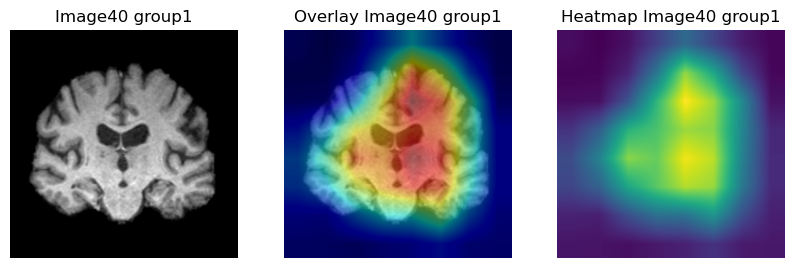

In [84]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img40_gr1)
axes[0].axis("off")
axes[0].set_title('Image40 group1')

axes[1].imshow(ov_img40_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group1')

axes[2].imshow(heat40_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group1')

### Second group => Image 40

Text(0.5, 1.0, 'Heatmap Image40 group2')

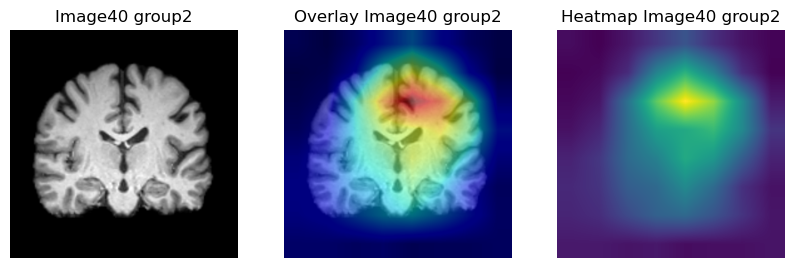

In [85]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img40_gr2)
axes[0].axis("off")
axes[0].set_title('Image40 group2')

axes[1].imshow(ov_img40_gr2)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group2')

axes[2].imshow(heat40_gr2)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group2')

## Checking minibatch approach

In [2]:
path1 = './adni_heatmaps/gr1_scd_64_modif.npy'

path2 = './adni_heatmaps/gr2_scd_64_modif.npy'

In [3]:
heat_gr1_scd = np.load(path1)

heat_gr2_scd = np.load(path2)

In [4]:
print(heat_gr1_scd.shape)

print(heat_gr2_scd.shape)

(64, 256, 256)
(64, 256, 256)


In [6]:
heat0_gr1_scd = heat_gr1_scd[0]

heat0_gr2_scd = heat_gr2_scd[0]

In [7]:
print(heat0_gr1_scd.shape)

(256, 256)


In [32]:
# We can choose either np.array_equal or np.allclose => This checkes for small floating point differences 

# np.array_eqaul
# np.allclose

print(heat0_gr1_scd.shape)

print(heat0_gr1.shape)

ar_equal = np.array_equal(heat0_gr1_scd, heat0_gr1)

print(ar_equal)

(256, 256)
(256, 256)
False


In [33]:
# Now we check if two arrays are close

ar_close = np.allclose(heat0_gr1_scd, heat0_gr1)

print(ar_close)

False


- The above two commands show tow np.arrays are not either equal nor close

In [39]:
from PIL import Image

In [40]:
img0_gr1_scd, ov_img0_gr1_scd = save_cam_with_alpha(img0_gr1, heat0_gr1_scd, alpha=0.5)

img0_gr2_scd, ov_img0_gr2_scd = save_cam_with_alpha(img0_gr2, heat0_gr2_scd, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
Error: Gradient map contains only zero values, cannot overlay.


In [42]:
# we adjust vmin and vmax of heatmaps for scaling

v_min_img0_scd, v_max_img0_scd = heat0_gr1_scd.min(), heat0_gr1_scd.max()

print(f'v_min_scd:{v_min_img0_scd:0.4f}')

print(f'v_max_scd:{v_max_img0_scd:0.4f}')

v_min_scd:13.8233
v_max_scd:136.1946


Text(0.5, 1.0, 'Heatmap Image0 group1 batch')

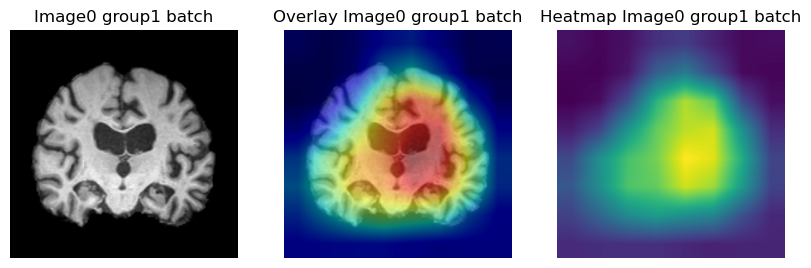

In [79]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img0_gr1_scd)
axes[0].axis("off")
axes[0].set_title('Image0 group1 batch')

axes[1].imshow(ov_img0_gr1_scd)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group1 batch')

axes[2].imshow(heat0_gr1_scd)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group1 batch')

In [43]:
# vmin and vmax from the first method

vmin_img0, vmax_img0 =  heat0_gr1.min(), heat0_gr1.max()

print(f'vmin_img0:{vmin_img0:0.4f}')

print(f'vmax_img0:{vmax_img0:0.4f}')

vmin_img0:13.8352
vmax_img0:136.2980


- It's really wierd, it shows already that two heatmaps have the same min and max.

- But I do not know why `np.allclose()` and `np.eq_array()` show there are differences between two np arrays

Text(0.5, 1.0, 'Heatmap Image0 group1')

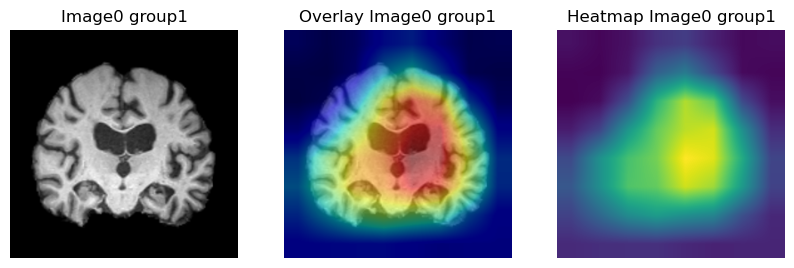

In [82]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img0_gr1)
axes[0].axis("off")
axes[0].set_title('Image0 group1')

axes[1].imshow(ov_img0_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group1')

axes[2].imshow(heat0_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group1')

- The second group has nothing in gradient

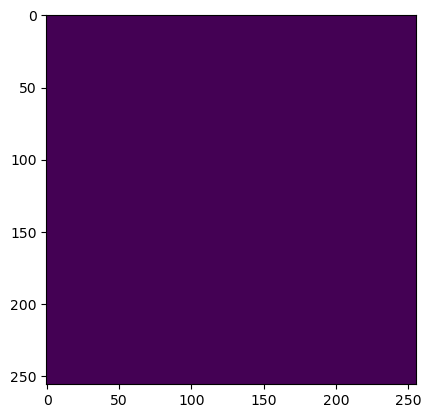

In [69]:
plt.imshow(heat_gr2[0])

### Minibatch approach => image 10

In [76]:
heat10_gr1_scd = heat_gr1[10]

heat10_gr2_scd = heat_gr2[10]

img10_gr1_scd, ov_img10_gr1_scd = save_cam_with_alpha(img10_gr1, heat10_gr1_scd, alpha=0.5)

img10_gr2_scd, ov_img10_gr2_scd = save_cam_with_alpha(img10_gr2, heat10_gr2_scd, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
Error: Gradient map contains only zero values, cannot overlay.


Text(0.5, 1.0, 'Heatmap Image10 group1 batch')

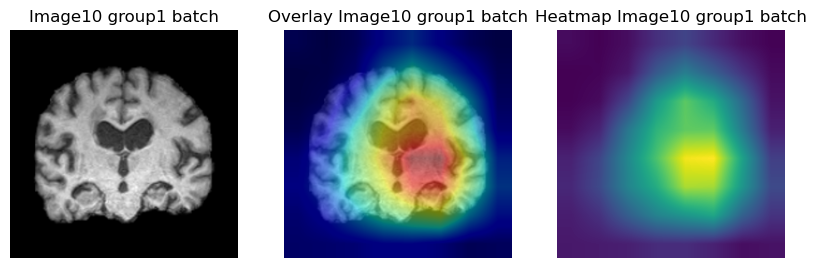

In [81]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img10_gr1_scd)
axes[0].axis("off")
axes[0].set_title('Image10 group1 batch')

axes[1].imshow(ov_img10_gr1_scd)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group1 batch')

axes[2].imshow(heat10_gr1_scd)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group1 batch')

Text(0.5, 1.0, 'Heatmap Image10 group1')

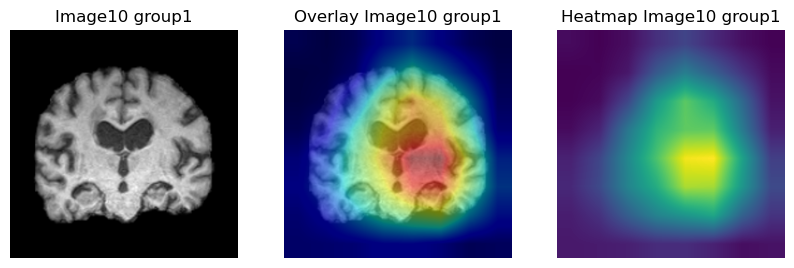

In [80]:
## Heat maps from the first approach 
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img10_gr1)
axes[0].axis("off")
axes[0].set_title('Image10 group1')

axes[1].imshow(ov_img10_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group1')

axes[2].imshow(heat10_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group1')

In [44]:
import torch

In [45]:
print(torch.__version__)

2.0.1


### Minibatch approach => image 40

In [86]:
heat40_gr1_scd = heat_gr1[40]

heat40_gr2_scd = heat_gr2[40]

img40_gr1_scd, ov_img40_gr1_scd = save_cam_with_alpha(img40_gr1, heat40_gr1_scd, alpha=0.5)

img40_gr2_scd, ov_img40_gr2_scd = save_cam_with_alpha(img40_gr2, heat40_gr2_scd, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
Error: Gradient map contains only zero values, cannot overlay.


Text(0.5, 1.0, 'Heatmap Image40 group1 batch')

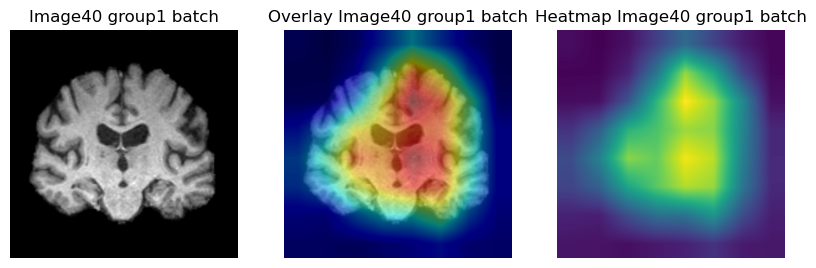

In [87]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img40_gr1_scd)
axes[0].axis("off")
axes[0].set_title('Image40 group1 batch')

axes[1].imshow(ov_img40_gr1_scd)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group1 batch')

axes[2].imshow(heat40_gr1_scd)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group1 batch')

Text(0.5, 1.0, 'Heatmap Image40 group1')

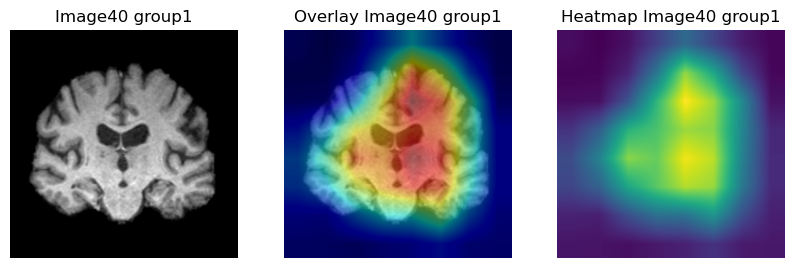

In [88]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img40_gr1)
axes[0].axis("off")
axes[0].set_title('Image40 group1')

axes[1].imshow(ov_img40_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group1')

axes[2].imshow(heat40_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group1')

In [89]:
print(heat_gr2.shape)

(64, 256, 256)


In [91]:
import numpy as np


# Check for zero-only heatmaps
zero_heatmap_indices = np.where(np.all(heat_gr2 == 0, axis=(1, 2)))[0]
nonzero_heatmap_indices = np.where(np.any(heat_gr2 != 0, axis=(1, 2)))[0]

print(f"Heatmaps with only zeros: {zero_heatmap_indices}")
print(f"Heatmaps with nonzero values: {nonzero_heatmap_indices}")

    
    

Heatmaps with only zeros: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Heatmaps with nonzero values: []


- **All heatmaps are zero in second group**

## Checking if increasing numbre of samples in each group changes things 

In [102]:
path1= './adni_heatmaps/gr1_scd_256_modif_(4591, 2048).npy'

heat_gr1_whole = np.load(path1)

path2 = './adni_heatmaps/gr2_scd_256_modif_(4592, 2048).npy'

heat_gr2_whole = np.load(path2)

In [103]:
heat0_gr1_w = heat_gr1_whole[0]

heat10_gr1_w = heat_gr1_whole[10]

heat40_gr1_w = heat_gr1_whole[40]

In [104]:
# Now lets' overlay these hetamaps on images 

img0_gr1, ov_img0_gr1_w = save_cam_with_alpha(img0_gr1, heat0_gr1_w, alpha=0.5)

img10_gr1, ov_img10_gr1_w = save_cam_with_alpha(img10_gr1, heat10_gr1_w, alpha=0.5)

img40_gr1, ov_img40_gr1_w = save_cam_with_alpha(img40_gr1, heat40_gr1_w, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)


### Image 0

Text(0.5, 1.0, 'Heatmap Image0 group1 whole')

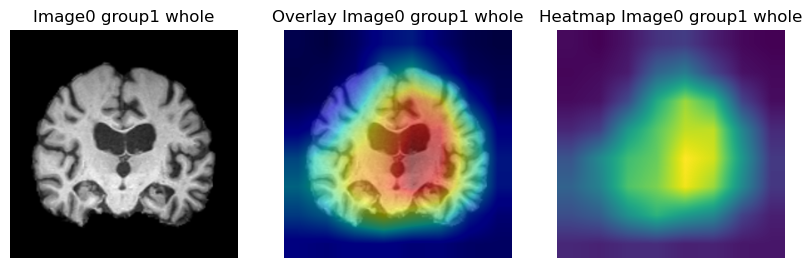

In [105]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img0_gr1)
axes[0].axis("off")
axes[0].set_title('Image0 group1 whole')

axes[1].imshow(ov_img0_gr1_w)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group1 whole')

axes[2].imshow(heat0_gr1_w)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group1 whole')

Text(0.5, 1.0, 'Heatmap Image0 group1')

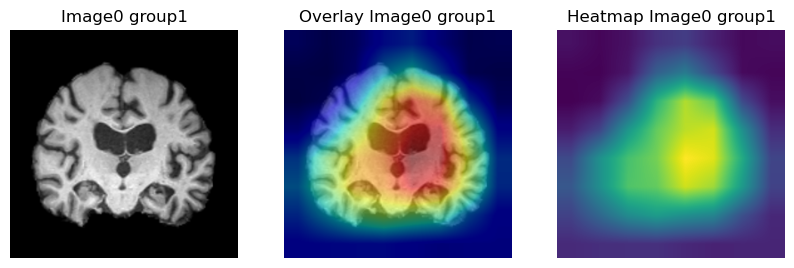

In [96]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img0_gr1)
axes[0].axis("off")
axes[0].set_title('Image0 group1')

axes[1].imshow(ov_img0_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image0 group1')

axes[2].imshow(heat0_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image0 group1')

### Image 10

Text(0.5, 1.0, 'Heatmap Image10 group1 whole')

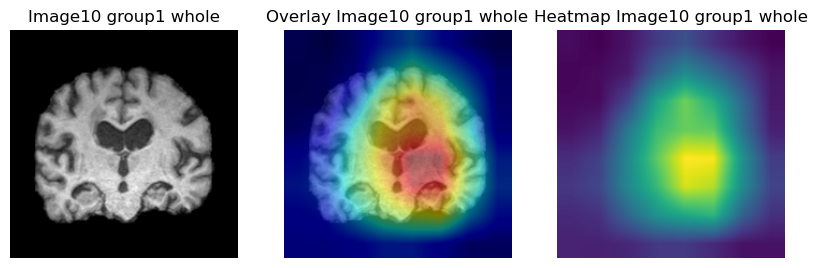

In [106]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img10_gr1)
axes[0].axis("off")
axes[0].set_title('Image10 group1 whole')

axes[1].imshow(ov_img10_gr1_w)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group1 whole')

axes[2].imshow(heat10_gr1_w)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group1 whole')

Text(0.5, 1.0, 'Heatmap Image10 group1')

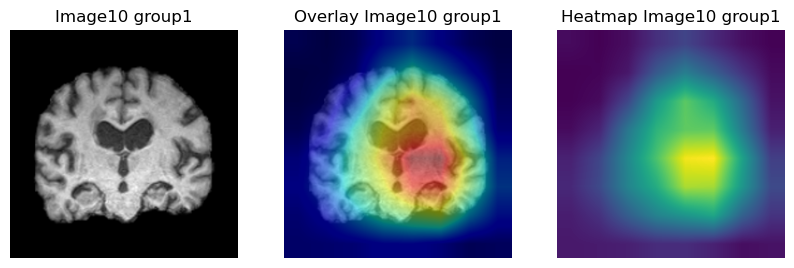

In [98]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img10_gr1)
axes[0].axis("off")
axes[0].set_title('Image10 group1')

axes[1].imshow(ov_img10_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image10 group1')

axes[2].imshow(heat10_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image10 group1')

### Image 40

Text(0.5, 1.0, 'Heatmap Image40 group1 whole')

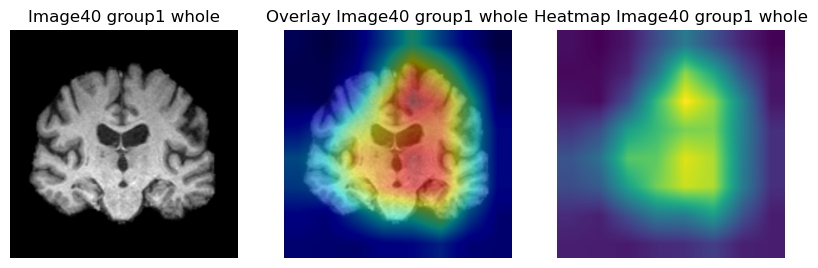

In [107]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img40_gr1)
axes[0].axis("off")
axes[0].set_title('Image40 group1 whole')

axes[1].imshow(ov_img40_gr1_w)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group1 whole')

axes[2].imshow(heat40_gr1_w)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group1 whole')

Text(0.5, 1.0, 'Heatmap Image40 group1')

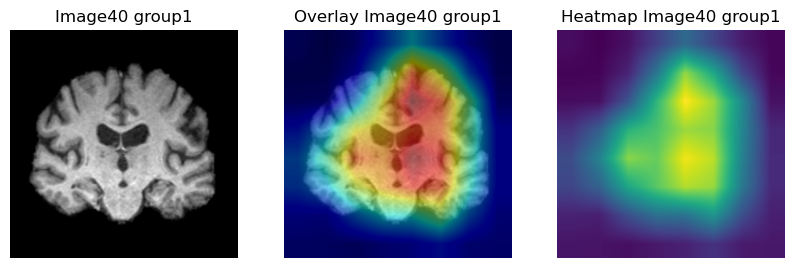

In [100]:
fig,axes = plt.subplots(1,3,figsize=(10,5))

axes[0].imshow(img40_gr1)
axes[0].axis("off")
axes[0].set_title('Image40 group1')

axes[1].imshow(ov_img40_gr1)
axes[1].axis("off")
axes[1].set_title('Overlay Image40 group1')

axes[2].imshow(heat40_gr1)
axes[2].axis("off")
axes[2].set_title('Heatmap Image40 group1')

#### This shows even if we include whole samples in the embeddings there is no change in the heatmaps.

- When I use **whole dataset** to take the mean embeddings and test-statistic is `0.7672`.

- When I use only 64 samples to get the embeddings, tets-statistic is `1.2030`.

## The effect of normalisation

- I changed normalisation and increased the sample size to 180.

- Here, I am trying to visualise the heatmaps.

In [27]:
path1 = './adni_heatmaps/gr1_180_n_nr.npy'

path2 = './adni_heatmaps/gr2_180_m_nr.npy'

In [28]:
gr1_heat = np.load(path1)

gr2_heat = np.load(path2)

In [29]:
print(gr1_heat.shape)

print(gr2_heat.shape)

(128, 256, 256)
(128, 256, 256)


In [35]:
gr0_128 = group0[:128]

gr1_128 = group1[:128]

In [36]:
img0_gr0, ov_im0_gr0 = save_cam_with_alpha(gr0_128, gr1_heat, alpha=0.5)

img0_gr1, ov_im0_gr1 = save_cam_with_alpha(gr1_128, gr2_heat, alpha=0.5)

Error: Gradient map contains only zero values, cannot overlay.
Error: Gradient map contains only zero values, cannot overlay.


## The effect of increasing the sample size

- I could not increase the number of samples due to OOM issue

In [91]:
print(os.listdir('./adni_heatmaps'))

['.ipynb_checkpoints', 'gr1.npy', 'gr1_100.npy', 'gr2.npy', 'gr2_100.npy']


In [96]:
path1 = './adni_heatmaps/gr1_180.npy'

path2 = './adni_heatmaps/gr2_180.npy'

In [97]:
gr_heat1 = np.load(path1)

gr_heat2 = np.load(path2)

In [98]:
gr_heat1.shape

(128, 256, 256)

In [99]:
gr_heat2.shape

(128, 256, 256)

In [100]:
path1 = './adni_heatmaps/gr1_190.npy'

path2 = './adni_heatmaps/gr2_190.npy'

gr_heat1 = np.load(path1)

gr_heat2 = np.load(path2)

print(gr_heat1.shape)

print(gr_heat2.shape)

(128, 256, 256)
(128, 256, 256)


- I could not increase the number of samples to 200, because of OOM error.

In [104]:
gr0_128 = group0[:128]

gr1_128 = group1[:128]

In [106]:
print(gr0_128.shape)

print(gr1_128.shape)

(128, 256, 256)
(128, 256, 256)


- Let's look at image0, image 10, image40 and image50

In [107]:
img0_gr1 = gr0_128[0]

img0_gr2 = gr1_128[0]

In [110]:
heat0_gr1 = gr_heat1[0]

heat0_gr2 = gr_heat2[0]

In [111]:
img0_gr0, ov_im0_gr0 = save_cam_with_alpha(img0_gr1, heat0_gr1, alpha=0.5)

img0_gr1, ov_im0_gr1 = save_cam_with_alpha(img0_gr2, heat0_gr2, alpha=0.5)

heatmap:(256, 256, 3)
image:(256, 256, 3)
heatmap:(256, 256, 3)
image:(256, 256, 3)


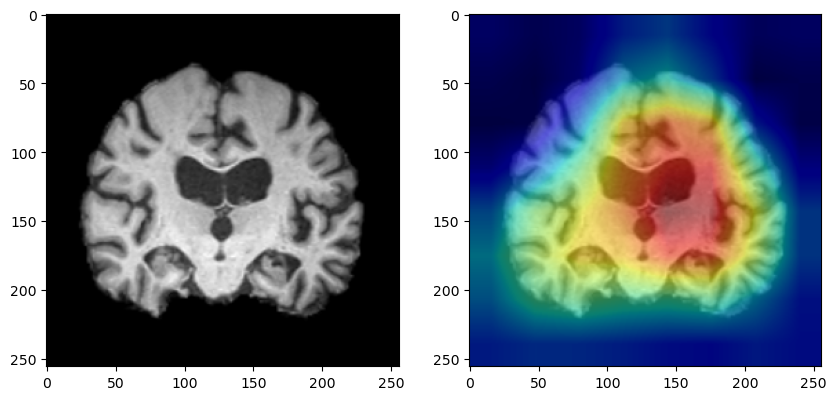

In [114]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img0_gr0)

axes[1].imshow(ov_im0_gr0)

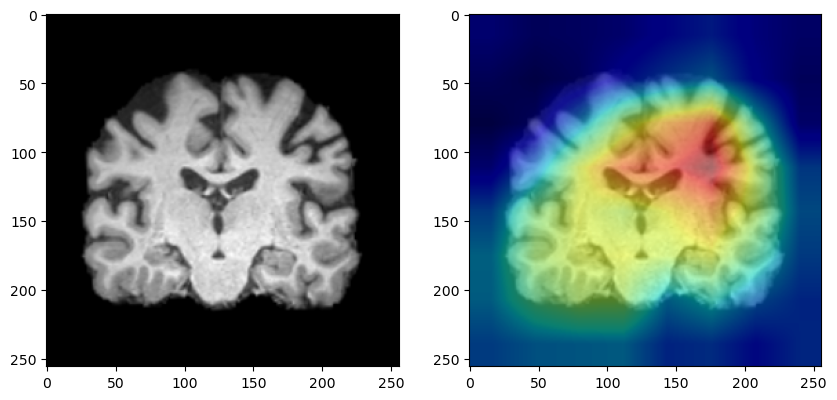

In [113]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(img0_gr1)

axes[1].imshow(ov_im0_gr1)

### Looking at Non-Max Factorization

- **Step1**: Load embeddings

- **Step2**: Make the NMF of embeddings of each groups

In [ ]:
from sklearn.decomposition import NMF

# Assuming V1 is the matrix of embeddings for Group 1
V1 = ...  # Shape (n1, d)

# Initialize NMF model with the desired number of components k
k = 10  # Number of concepts/features
model_1 = NMF(n_components=k, init='random', random_state=42)

# Fit the model to Group 1's embeddings and obtain W1 and H1
W1 = model_1.fit_transform(V1)  # Shape (n1, k)
H1 = model_1.components_         # Shape (k, d)

- Now you have:
  
  - **W1** and **W2**: The **basis** matrices for each group, where each rwo represents a learned concept
  
  - **H1** and **H2**: The **coefficients** matrices for each group, representing the weights of the learned concepts for each embedding. 

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


In [16]:
from sklearn.decomposition import NMF

- Load embeddings of each group

In [22]:
gr1_embed = np.load('./adni_embed/embed_gr1.npy')

gr2_embed = np.load('./adni_embed/embed_gr1.npy')

In [23]:
print(gr1_embed.shape)

print(gr2_embed.shape)

(4591, 2048)
(4591, 2048)


- I take only 200 samples from each group

In [34]:
gr1_embed200 = gr1_embed[:200,:]
gr2_embed200 = gr2_embed[:200,:]

In [35]:
print(gr1_embed200.shape)
print(gr2_embed200.shape)

(200, 2048)
(200, 2048)


- I decreased the numebr of samples to see if I can observe the convergence

- I got the following error in NMF:

  - init = 'nndsvd' can only be used when n_components <= min(n_samples, n_features)
  
- I deleted k=500, as I got the above error

- Note that if we inacrease the number of components, then complexity of alorithm increases


In [25]:
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [41]:
def get_NMF(V, k=10):
    """It takes a laten dimention k and factor matrix of emebddings
       as the multiplication of two low rank matrices
       INPUT:V : nxd, where n is the number of samples in dataset, d is the dimension of mebeddings
       OUTPUT: W: nxk, where k is number of components (concepts)
             : H: kxd, where
    """
    # Try different values for the number of components (k)
    # component_range = [10, 20, 50, 100, 200, 500]
    
    component_range = [10, 20, 50, 100, 200]
    reconstruction_errors = []
    W_list = []
    H_list = []
    
    for k in component_range:
        print(f'k={k}')
        model = NMF(n_components=k, init='nndsvd', random_state=42, max_iter=2000, tol=1e-4)
        W = model.fit_transform(V)
        H = model.components_
        
        W_list.append(W)
        H_list.append(H)
        
        # Reconstruct the data from W and H
        V_reconstructed = np.dot(W, H)
    
        # Compute the reconstruction error (mean squared error)
        error = mean_squared_error(V, V_reconstructed)
        reconstruction_errors.append(error)
        
    # Plot reconstruction error as a function of number of components
    plt.plot(component_range, reconstruction_errors, marker='o')
    plt.xlabel('Number of Components (k)')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title('Reconstruction Error vs. Number of Components')
    plt.show()
    
    return(W_list, H_list)
        

k=10


/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


k=20


/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


k=50


/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


k=100


/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


k=200


/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


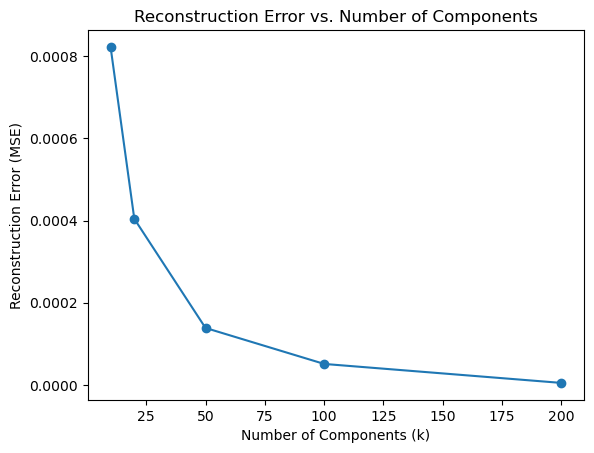

In [42]:
W1_list, H1_list = get_NMF(gr1_embed200) 


- Based on the above plot, it seems that **k=50** or **k=100** might be a good choice.

k=10


/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


k=20


/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


k=50


/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


k=100


/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


k=200


/dhc/home/masoumeh.javanbakhat/anaconda3/envs/myenv2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


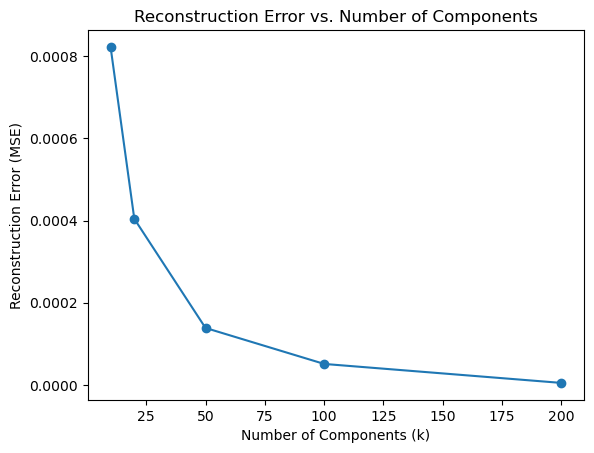

In [43]:
W2_list, H2_list = get_NMF(gr2_embed200) 

- Based on the above plot, we see that using number of concepts equal to **50 or 100** would be fine.

In [50]:
W1_gr1_50 = W1_list[2]

W2_gr2_50 = W2_list[2]

In [51]:
print(W1_gr1_50.shape)

print(W2_gr2_50.shape)

(200, 50)
(200, 50)


- Let's look at columns of matrix: W1_gr1_50

- Also, I want to look at columns of matrix W2_gr2_50

In [60]:
for i in range(50):
    
    print(f'col{i}:{W1_gr1_50[:,i]}\n')

col0:[0.4315144  0.30652523 0.45865566 0.51701164 0.47541034 0.4658098
 0.4211643  0.5119583  0.5684543  0.48782372 0.5447376  0.2827098
 0.15653192 0.32251933 0.42711753 0.43401295 0.48382849 0.43939
 0.4977534  0.5201678  0.4243624  0.45670936 0.5139085  0.458355
 0.3302416  0.4400833  0.36875534 0.39131635 0.38003924 0.39297113
 0.44545257 0.4089798  0.43800437 0.5071147  0.4068679  0.43653378
 0.5012129  0.3863126  0.39528635 0.49731213 0.38426134 0.49777147
 0.5403625  0.25320935 0.3285087  0.28942078 0.66602457 0.5863532
 0.6041393  0.5703321  0.64823794 0.61031765 0.6172818  0.6310994
 0.595524   0.6472086  0.32233286 0.40457472 0.44642985 0.439683
 0.3546271  0.468684   0.46058238 0.48724276 0.43158984 0.42388797
 0.37347922 0.45750263 0.2415581  0.395476   0.41774383 0.24984969
 0.44186252 0.48371387 0.28610843 0.38321236 0.3337954  0.44300756
 0.33135214 0.36207274 0.46514487 0.42925924 0.4401792  0.37586948
 0.4762099  0.46348086 0.33331713 0.3364577  0.4118662  0.3796724
 0

In [61]:
for i in range(50):
    
    print(f'col{i}:{W2_gr2_50[:,i]}\n')

col0:[0.4315144  0.30652523 0.45865566 0.51701164 0.47541034 0.4658098
 0.4211643  0.5119583  0.5684543  0.48782372 0.5447376  0.2827098
 0.15653192 0.32251933 0.42711753 0.43401295 0.48382849 0.43939
 0.4977534  0.5201678  0.4243624  0.45670936 0.5139085  0.458355
 0.3302416  0.4400833  0.36875534 0.39131635 0.38003924 0.39297113
 0.44545257 0.4089798  0.43800437 0.5071147  0.4068679  0.43653378
 0.5012129  0.3863126  0.39528635 0.49731213 0.38426134 0.49777147
 0.5403625  0.25320935 0.3285087  0.28942078 0.66602457 0.5863532
 0.6041393  0.5703321  0.64823794 0.61031765 0.6172818  0.6310994
 0.595524   0.6472086  0.32233286 0.40457472 0.44642985 0.439683
 0.3546271  0.468684   0.46058238 0.48724276 0.43158984 0.42388797
 0.37347922 0.45750263 0.2415581  0.395476   0.41774383 0.24984969
 0.44186252 0.48371387 0.28610843 0.38321236 0.3337954  0.44300756
 0.33135214 0.36207274 0.46514487 0.42925924 0.4401792  0.37586948
 0.4762099  0.46348086 0.33331713 0.3364577  0.4118662  0.3796724
 0

### Distance between concepts

- # Compute the Euclidean distance between corresponding concepts (rows) in W1 and W2

In [52]:
distance_matrix = np.linalg.norm(W1_gr1_50 - W2_gr2_50, axis=1)

In [53]:
distance_matrix.shape

(200,)

In [62]:
distance_matrix[:4]

array([0., 0., 0., 0.], dtype=float32)

In [54]:
distance_matrix[0]

0.0

- We can also look at cosine similarity to see the differences between two matrices. 

- Alternatively, we could use cosine similarity to measure how similar the learned concepts are between the two groups

In [73]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute pairwise cosine similarity between columns of W1 and W2
cosine_sim = cosine_similarity(W1_gr1_50.T, W2_gr2_50.T)  # Shape (50 x 50)

In [74]:
cosine_sim.shape

(50, 50)

In [79]:
W1_gr1_50.shape

(200, 50)

- This will give a (50x50) matrix, 

  - Where i represents the similarity of i'th concept with all concepts in matrix W2
  
  - Colj represents the similarity of the jth concept to all concepts in W1

- If cosine_sim[i, j] is close to 1, the jth concept of W1 and the jth concept of W2 are very similar. 

- If cosine_sim[i,j] is 0. They are not related.

- If cosine_sim[i,j] is -1, They are opposite. 


- Visualaising cosine similarity

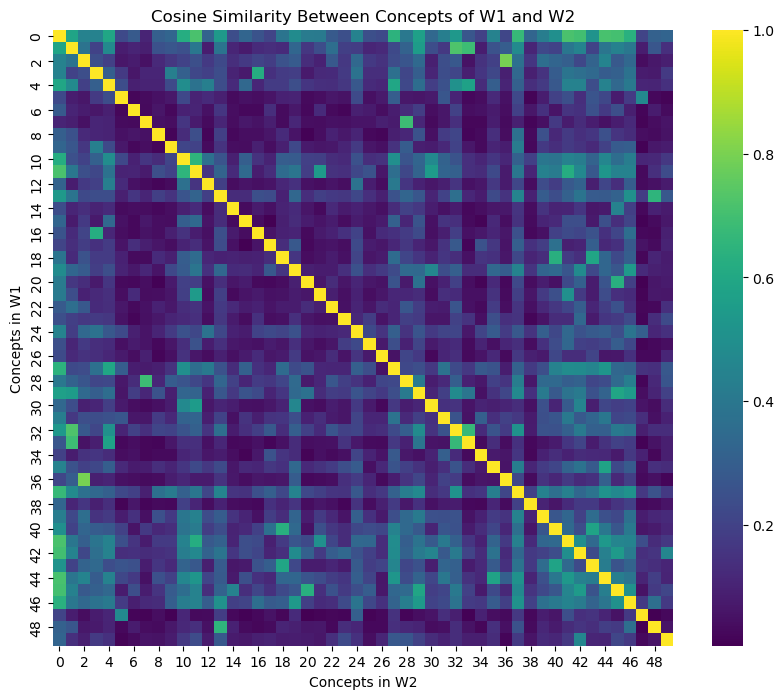

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim, cmap="viridis", annot=False)
plt.xlabel("Concepts in W2")
plt.ylabel("Concepts in W1")
plt.title("Cosine Similarity Between Concepts of W1 and W2")
plt.show()

### Something that Prof. Samak shared:

 - https://github.com/dilyabareeva/quanda
 
 - https://github.com/understandable-machine-intelligence-lab/Quantus
 
 - https://arxiv.org/abs/2412.06639